### Using Documentation

Let's start by using the available documentation to pick a hardware injection we want to recover. From the S5 CBC hardware injection page, follow the link to the table of injections for H1. We'll pick an injection with a relatively high SNR for the tutorial. Scroll down until you see GPS time 817064899. You should see a line in the table that looks like this:

817064899 	H1 	10 	10 	25 	Successful 	28.16 	26.55 

### Getting Data

xxxxxxxxx





If you do not already know how to download and read a LIGO data file, you may want to start with the Introduction to LIGO Data Files. As a reminder, to download this data file, follow the menu link to Data & Catalogs to find the S5 Data Archive.
- Navigate to the [S5 Data Archive](https://losc.ligo.org/archive/S5)
- Select the H1 instrument
- Input the injection time as both the start and end of your query.
- Click submit

This should return a result with only the data file containing the injection.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import readligo as rl
%matplotlib inline

In [10]:
strain, time, dq = rl.loaddata('H-H1_LOSC_4_V1-817061888-4096.hdf5')
dt = time[1] - time[0]
fs = 1.0 / dt
print(dq.keys())

dict_keys(['DATA', 'CBCHIGH_CAT1', 'CBCHIGH_CAT2', 'CBCHIGH_CAT3', 'CBCHIGH_CAT4', 'CBCLOW_CAT1', 'CBCLOW_CAT2', 'CBCLOW_CAT3', 'CBCLOW_CAT4', 'BURST_CAT1', 'BURST_CAT2', 'BURST_CAT3', 'BURST_CAT2E', 'BURST_CAT3E', 'CW_CAT1', 'STOCH_CAT1', 'STOCH_CAT2_H1L1', 'STOCH_CAT2_H2L1', 'PEM', 'HW', 'HW_CBC', 'HW_BURST', 'HW_STOCH', 'CW', 'DEFAULT'])


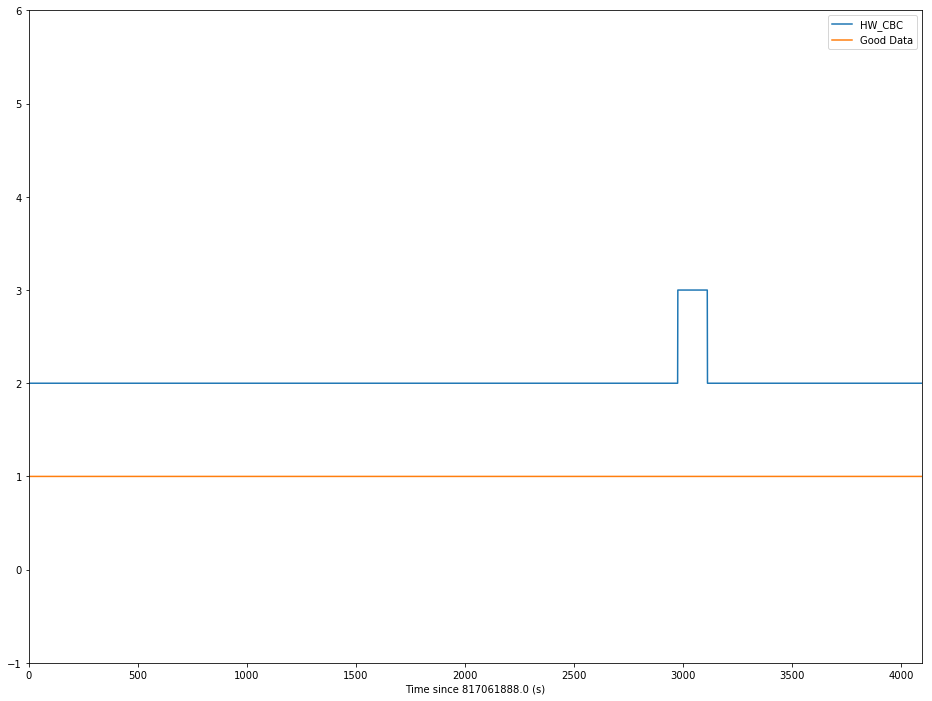

In [11]:
plt.figure(figsize=(16,12))
plt.plot(dq['HW_CBC'] + 2, label='HW_CBC')
plt.plot(dq['DEFAULT'], label='Good Data')
plt.xlabel('Time since ' + str(time[0]) + ' (s)')
plt.axis([0, 4096, -1, 6])
plt.legend()
plt.show()

Notice that all the time around the injection passes the default data quality flags (DEFAULT is 1), so we should have no problems analyzing this time.

Finally, let's grab the segment of data containing the injection. We'll also identify a segment of data just before the injection, to use for a PSD estimation. We'll call this the "noise" segment, and it will be 8 times as long as the segment containing the injection.

In [12]:
# -- Get the injection segment
inj_slice = rl.dq_channel_to_seglist(dq['HW_CBC'])[0]
inj_data = strain[inj_slice]
inj_time = time[inj_slice]

# -- Get the noise segment
noise_slice = slice(inj_slice.start-8*len(inj_data), inj_slice.start)
noise_data = strain[noise_slice]

# -- How long is the segment?
seg_time = len(inj_data) / fs
print("The injection segment is {0} s long".format(seg_time))

The injection segment is 136.0 s long


In [15]:
# -- Make a frequency domain template
import template
temp, temp_freq = template.createTemplate(4096, seg_time, 10, 10)

/Users/tarrysingh/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [16]:
# -- LIGO noise is very high below 25 Hz, so we won't search there
temp[temp_freq < 25] = 0

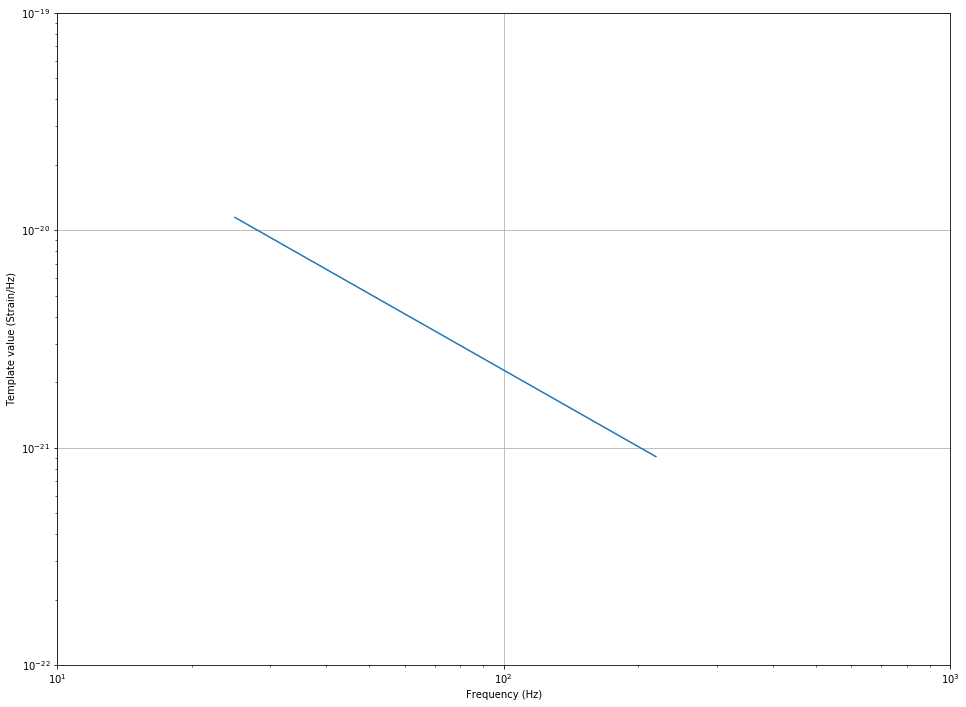

In [17]:
# Plot the template
plt.figure(figsize=(16,12))
plt.loglog(temp_freq, abs(temp))
plt.axis([10, 1000, 1e-22, 1e-19])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Template value (Strain/Hz)")
plt.grid()

In [18]:
# Window and FFT the data
window = np.blackman(inj_data.size)
data_fft = np.fft.rfft(inj_data*window)

In [ ]:
# Take PSD of noise segment
PXX, PSD_Freq = 